In [12]:
!git clone https://github.com/JordanFoss/STAT3007_Project.git
%cd STAT3007_Project/

Cloning into 'STAT3007_Project'...
remote: Enumerating objects: 3734, done.
remote: Counting objects: 100% (12/12), done.
remote: Compressing objects: 100% (11/11), done.
remote: Total 3734 (delta 4), reused 4 (delta 1), pack-reused 3722
Receiving objects: 100% (3734/3734), 657.71 MiB | 19.20 MiB/s, done.
Resolving deltas: 100% (589/589), done.
Checking out files: 100% (2785/2785), done.
/content/STAT3007_Project


In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F

import numpy as np
import matplotlib.pyplot as plt
import sys
import os
import glob
import librosa
import soundfile as sf
from librosa import display

import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, random_split
from torch.autograd import Variable

# Some useful functions

In [43]:
def find_min_max():

  min_time = 41241
  max_time = 0
  min_sample = 0
  max_sample = 0
  for folder_name in glob.glob('./truncated_samples/*'):
    for actor_folder in glob.glob(folder_name + '/*'):
      for sample_path in glob.glob(actor_folder + '/*'):
        sample_name = sample_path.split('/')[-1]
        file_format = sample_name.split('.')[-1]

        # # we want only audio files, selected emotions and strong intensity
        # if file_format != 'wav' or sample_name[:2] not in target_map or sample_name[3:5] == '01':
        #   continue
        
        sample, sampling_rate = librosa.load(sample_path, sr = None)

        sampling_time = sample.shape[0]/sampling_rate

        if sampling_time < min_time:
          min_time = sampling_time
          min_sample = sample.shape[0]
          min_file = sample_name

        if sampling_time > max_time:
          max_time = sampling_time
          max_sample = sample.shape[0]
          max_file = sample_name

  return min_time, max_time, min_sample, max_sample, min_file, max_file

In [2]:
def mel_spectral_decomposition(sample,sampling_rate, title = ' title placeholder', visualise = False):

  spectrogram = librosa.feature.melspectrogram(y=sample, sr=sampling_rate, n_mels=128,fmax=8000) 
  spectrogram = librosa.power_to_db(spectrogram)

  if visualise:
    librosa.display.specshow(spectrogram, y_axis='mel', fmax=8000, x_axis='time', sr =sampling_rate);
    plt.title(title)
    plt.colorbar(format='%+2.0f dB')

  return spectrogram

In [3]:
def pre_pad(samples, max_sample):
  sample_duration = samples.shape[0]

  num_to_pad = max_sample - sample_duration
  padded_sample = np.pad(samples,(num_to_pad,0),'constant', constant_values = 0)

  return padded_sample

In [4]:
def amp_normalisation(sample):
  mean = np.mean(sample)
  std = np.sqrt(np.var(sample))
  return (sample - mean)/std

In [27]:
# find its clean version of the noisy file
def find_clean_file(noisy_path):
    clean_path = '/content/STAT3007_Project/truncated_samples'
    base = os.path.basename(noisy_path).split("_")[0]
    actor = base.split('-')[-1]
    if int(actor) % 2 == 1:
        clean_path = os.path.join(clean_path, 'Male')
    else:
        clean_path = os.path.join(clean_path, 'Female')
    clean_path = os.path.join(clean_path, 'Actor_' + actor)
    clean_path = os.path.join(clean_path, base+'.wav')

    return clean_path


In [5]:
class DatasetWrapper(Dataset):
  def __init__(self, X, y):
    self.X, self.y = X, y

  def __len__(self):
    return len(self.X)

  def __getitem__(self, idx):
    return self.X[idx], self.y[idx]
  
  def change_type(self, dtype):

    return DatasetWrapper(self.X.type(dtype),self.y.type(dtype))
  
  def dataset(self):
    return DatasetWrapper(self.X,self.y)
  
  def get_data(self):
    return self.X, self.y

In [6]:
# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device == torch.device('cuda'))

True


# Take a look at the mel spectrogram for noisy and test data

In [20]:
noisy_file = '/content/STAT3007_Project/sample-noisy-speech-actor-11/02-02-02-01-11_AirConditioner_1.wav'
clean_file = '/content/STAT3007_Project/truncated_samples/Male/Actor_11/02-02-02-01-11.wav'

In [8]:
clean_samples, clean_freq = librosa.load(clean_file, sr=None)

(128, 214)


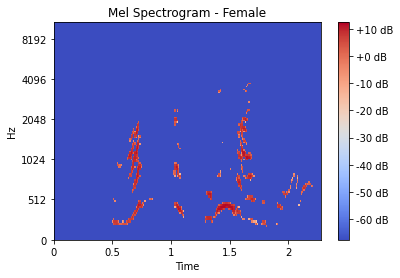

In [33]:
spectrogram = mel_spectral_decomposition(clean_samples, clean_freq)
print(spectrogram.shape)
spectrogram = librosa.power_to_db(spectrogram)
plt.figure()
librosa.display.specshow(spectrogram, y_axis='mel', fmax=None, x_axis='time', sr = clean_freq);
plt.title('Mel Spectrogram - Female')
plt.colorbar(format='%+2.0f dB');

array([[-62.64266 , -62.64266 , -58.202072, ..., -56.36791 , -61.06466 ,
        -62.64266 ],
       [-61.06903 , -60.351734, -56.611618, ..., -62.64266 , -52.233704,
        -52.15982 ],
       [-60.245205, -62.64266 , -62.076256, ..., -49.41011 , -49.162144,
        -62.535446],
       ...,
       [-59.858112, -59.865833, -62.64266 , ..., -62.64266 , -62.64266 ,
        -62.64266 ],
       [-60.29859 , -60.491325, -62.64266 , ..., -62.64266 , -62.425823,
        -61.077766],
       [-53.334316, -56.473274, -59.246693, ..., -62.64266 , -61.32164 ,
        -60.67818 ]], dtype=float32)

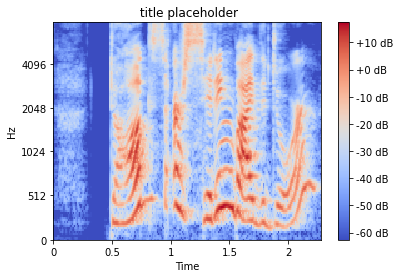

In [37]:
mel_spectral_decomposition(clean_samples, clean_freq, visualise=True)

In [10]:
noisy_samples, noisy_freq = librosa.load(noisy_file, sr=None)

array([[ -2.4773593,  -5.086231 ,  -1.4225875, ...,  -3.0217493,
        -13.419638 , -16.296103 ],
       [ -8.725031 , -20.076082 ,  -4.6842947, ...,  -7.932277 ,
        -11.665087 ,  -9.210151 ],
       [-17.694897 , -13.436396 ,  -5.9282966, ...,  -9.827385 ,
         -8.695942 ,  -7.887997 ],
       ...,
       [-53.747482 , -57.06129  , -62.350697 , ..., -62.65554  ,
        -62.65554  , -62.65554  ],
       [-58.803577 , -60.062527 , -62.65554  , ..., -62.65554  ,
        -62.359123 , -61.456512 ],
       [-58.245285 , -58.348736 , -59.29042  , ..., -62.65554  ,
        -60.98935  , -60.22446  ]], dtype=float32)

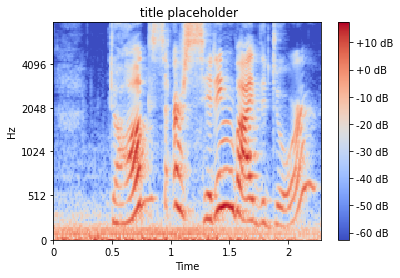

In [35]:
mel_spectral_decomposition(noisy_samples, noisy_freq, visualise=True)

# Training and testing data


In [28]:
noisy_data_path = '/content/STAT3007_Project/sample-noisy-speech-actor-11'
# Note that the clean data is the truncated data
clean_data_path = '/content/STAT3007_Project/truncated_samples/Male/Actor_11'

In [45]:
# find max sample to pad
min_time, max_time, min_sample, max_sample, min_file, max_file = find_min_max()

In [48]:
max_sample

211873

In [50]:
# Get the normalised, pre-padded noisy and clean mel spectrogram data

noisy_spectrograms = []
clean_spectrograms = []
for noisy_file in glob.glob(os.path.join(noisy_data_path, '*.wav')):
    noisy_samples, noisy_sampling_rate = librosa.load(noisy_file, sr = None)
    noisy_samples = ( noisy_samples - np.mean(noisy_samples) ) / np.std(noisy_samples)
    noisy_samples = pre_pad(noisy_samples, max_sample)
    noisy_spectrogram = mel_spectral_decomposition(noisy_samples, noisy_sampling_rate)
    # print('noisy_spectrogram shape:' + str(noisy_spectrogram.shape))
    noisy_spectrograms.append(noisy_spectrogram)

    clean_file = find_clean_file(noisy_file)
    clean_samples, clean_sampling_rate = librosa.load(clean_file, sr = None)
    clean_samples = ( clean_samples - np.mean(clean_samples) ) / np.std(clean_samples)
    clean_samples = pre_pad(clean_samples, max_sample)
    clean_spectrogram = mel_spectral_decomposition(clean_samples, clean_sampling_rate)
    # print('clean_spectrogram shape:' + str(clean_spectrogram.shape))
    clean_spectrograms.append(clean_spectrogram)

noisy_spectrograms = np.asarray(noisy_spectrograms)
clean_spectrograms = np.asarray(clean_spectrograms)

In [53]:
print(noisy_spectrograms.shape)
print(clean_spectrograms.shape)

(790, 128, 414)
(790, 128, 414)


In [56]:
# train test split
spectro_data = DatasetWrapper(noisy_spectrograms, clean_spectrograms)
train_size = int(noisy_spectrograms.shape[0] * 0.9)
test_size = noisy_spectrograms.shape[0] - train_size
data_test, data_train = random_split(spectro_data,[test_size,train_size], generator = torch.Generator().manual_seed(10))

# The Autoencoder


In [69]:
class Encoder(nn.Module):
  def __init__(self, filters):
    super(Encoder, self).__init__()
    (W, K, S) = (28, 5, 1)
    P = (W*S-W-S+K)//2
    self.conv = nn.Conv2d(1, filters, K, S, P)
  def forward(self, x):
    x = self.conv(x)
    x = nn.functional.relu(x)
    return x


class Decoder(nn.Module):
  def __init__(self, filters):
    super(Decoder,self).__init__()
    (W, K, S) = (28, 1, 1)
    P = (W*S-W-S+K)//2
    self.conv = nn.Conv2d(filters, 1, K, S, P)
  def forward(self, x):
    x = self.conv(x)
    x = nn.functional.relu(x)
    return x

class Autoencoder(nn.Module):
  def __init__(self, filters):
    super(Autoencoder,self).__init__()
    self.filters = filters
    self.encoder = Encoder(filters)
    self.decoder = Decoder(filters)
  def forward(self, x):
    x = self.encoder(x)
    x = self.decoder(x)
    return x

In [64]:
# test of the data loader
data_loader = DataLoader(data_train,
                         batch_size = 10, shuffle = True)

In [66]:
for x_batch, y_batch in data_loader:
    x_batch = x_batch[:,None,:,:]
    print(x_batch.shape)
    print(y_batch.shape)
    break

torch.Size([10, 1, 128, 414])
torch.Size([10, 128, 414])


In [67]:
def train(model, data, nepochs, lr, batch_size, use_cuda=False):

    device = None
    if use_cuda and torch.cuda.is_available():
        dtype = torch.cuda.FloatTensor
        device = torch.device("cuda")
        net = net.to(device)
    else:
        dtype = torch.FloatTensor
    data = data.dataset.change_type(dtype)

    data_loader = DataLoader(data, batch_size = batch_size, 
                             shuffle = True)

    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    for epoch in range(nepochs):
        total_loss = 0
        for x_batch, y_batch in data_loader:
            # add another channel dimension
            x_batch = x_batch[:,None,:,:].to(device)
            y_batch = y_batch[:,None,:,:].to(device)
            optimizer.zero_grad()
            out = model(x_batch)
            loss = criterion(out, y_batch)
            loss.backward()
            total_loss += loss
            optimizer.step()
        print("Epoch: {}  Loss {}".format(epoch, total_loss))


In [70]:
model = Autoencoder(4).to(device)
nepochs = 50
lr = 0.01
batch_size = 10
# have not trained coz AE structure has not been resolved
train(model, data_train, nepochs, lr, batch_size, use_cuda=True)